**Name** : Mehmet Ehliz

E-mail :

### Module Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras import optimizers, regularizers
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Useful Jupyter Notebook Shortcuts

Here are some helpful keyboard shortcuts for Jupyter Notebook:

- **M**: Switch to Markdown mode
- **Y**: Switch to Code mode
- **A**: Insert cell above
- **B**: Insert cell below
- **D, D**: (Press D twice) Delete selected cell
- **Shift + Enter**: Run the current cell and move to the next
- **Ctrl + Enter**: Run the current cell and stay on it
- **Shift + Tab**: Show function/method documentation
- **Ctrl + Shift + -**: Split cell at cursor
- **Esc**: Enter command mode (blue border)
- **Enter**: Enter edit mode (green border)


## Make a table in markdown :

```
| Architecture | Scaled | Epochs | mse  | val_mse | $R^2$ |
|--------------|--------|--------|------|---------|-------|
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
```

Note: The number of spaces used in this markdown table is just for visual formatting and is not mandatory. The table will render correctly even with minimal spacing.

will generate :
| Architecture | Scaled | Epochs | mse  | val_mse | $R^2$ |
|--------------|--------|--------|------|---------|-------|
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |
|              |        |        |      |         |       |

### Local Functions

In [2]:
def read_fixed_width_file(file_path: str, skip_lines: int = 0) -> tuple[pd.DataFrame, dict[str, str]]:
    """
    Read a fixed-width file into a pandas DataFrame and return associated units.

    This function reads a specific fixed-width file format containing information about
    red giant stars. It creates a pandas DataFrame from the file contents and provides
    a dictionary of units for each column.

    :param file_path: Path to the fixed-width file.
    :type file_path: str
    :param skip_lines: Number of lines to skip at the beginning of the file, defaults to 0.
    :type skip_lines: int, optional

    :return: A tuple containing the pandas DataFrame and a dictionary of units.
    :rtype: Tuple[pd.DataFrame, Dict[str, str]]

    :raises FileNotFoundError: If the specified file_path does not exist.
    :raises pd.errors.EmptyDataError: If the file is empty.

    .. note::
        The file is expected to have the following columns:
        Type, 2MASS, Teff, log(g), [Fe/H], [a/Fe], lnM, lnAge, chi2, GALR,
        e_Teff, e_log(g), e_[Fe/H], e_[a/Fe], e_logM, e_logAge

    .. warning::
        This function is designed for a specific file format. Using it with different
        file formats may lead to unexpected results.

    Example:
        >>> file_path = 'path/to/your/apj523069t1_mrt.txt'
        >>> df, units = read_fixed_width_file(file_path, skip_lines=5)
        >>> print(df.head())
        >>> print(units)
    """
    # Define the column specifications
    col_specs = [
        (0, 7), (9, 15), (17, 20), (22, 25), (27, 32), (34, 38),
        (40, 43), (45, 48), (50, 54),
    ]

    # Define the column names
    col_names = [
        'RAdeg', 'Dedeg', 'Teff', 'log(g)', '[Fe/H]', '[a/Fe]',
        'mass_in', 'mass', 'age'
    ]

    # Define the units for each column
    units = {
        'Teff': 'K',
        'log(g)': '[cm/s2]',
        '[Fe/H]': '[Sun]',
        '[a/Fe]': '[Sun]',
        'mass_in': '[sol. Mass]',
        'mass': '[sol. Mass]',
        'age': '[Gyr]',
    }

    # Read the file using read_fwf function
    df = pd.read_fwf(file_path,
                     colspecs=col_specs,
                     names=col_names,
                     encoding='utf-8',
                     skiprows=skip_lines)

    return df, units


In [3]:
def scaled_train_test_split(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Scale the training and test DataFrames using StandardScaler.

    This function applies StandardScaler to the input DataFrames, fitting the scaler
    on the training data and then transforming both training and test data.

    Parameters
    ----------
    df_train : pd.DataFrame
        The training DataFrame to be scaled.
    df_test : pd.DataFrame
        The test DataFrame to be scaled.

    Returns
    -------
    tuple[pd.DataFrame, pd.DataFrame]
        A tuple containing the scaled training DataFrame and the scaled test DataFrame.

    Raises
    ------
    ValueError
        If df_train and df_test do not have the same columns.
    AssertionError
        If either df_train or df_test is empty.

    Examples
    --------
    >>> train_df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
    >>> test_df = pd.DataFrame({'A': [7, 8], 'B': [9, 10]})
    >>> scaled_train, scaled_test = scaled_train_test(train_df, test_df)
    """
    assert not df_train.empty, "Training DataFrame is empty"
    assert not df_test.empty, "Test DataFrame is empty"

    if not df_train.columns.equals(df_test.columns):
        raise ValueError("Training and test DataFrames must have the same columns")

    scaler = StandardScaler()
    scaled_df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
    scaled_df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

    return scaled_df_train, scaled_df_test

### global variables

In [4]:
DATASET_URL = "https://content.cld.iop.org/journals/0067-0049/249/1/7/revision1/apjsab8bcdt8_mrt.txt"
RANDOM_SEED = 42

# Dataset Preparation

## downloading data

In [7]:
df_planets, units = read_fixed_width_file(DATASET_URL,20)
# Display the first few rows of the DataFrame to verify the data
print(df_planets.head())
# Display basic information about the DataFrame
print(units)

     RAdeg  Dedeg  Teff  log(g)  [Fe/H]  [a/Fe]  mass_in  mass  age
0  323.912  7.497   408     1.3   -0.00     0.0      1.5   1.5  2.9
1  323.949  0.553   468     2.8    0.07     0.1      1.0   1.0  9.0
2  324.011  5.520   449     1.7   -0.43     0.0      1.2   1.4  1.9
3  324.012  0.840   468     2.5    0.04     0.0      2.1   1.4  4.8
4  324.023  3.767   462     2.6    0.23     0.0      1.3   1.4  4.1
{'Teff': 'K', 'log(g)': '[cm/s2]', '[Fe/H]': '[Sun]', '[a/Fe]': '[Sun]', 'mass_in': '[sol. Mass]', 'mass': '[sol. Mass]', 'age': '[Gyr]'}


## Data Analysis

In [38]:
print("Shape of the dataset is", df_planets.shape)
# There are nine columns so the resuls are making sense.

print("")

#The numbe of column can be also found directly with index number
print("Number of columns is", len(df_planets.columns))
print("")

# The last column is not a feature, it is target value
print("Number of features is", len(df_planets.columns)-1)
print("")

# Each star must have all 8 features if the one hasn't then we can conclude that
# there is a missing value.

if (df_planets.isnull().sum().sum() == 0):
    print("There is no missing value")
else:
    print("There is missing value")

print("")

# Range of each feature is the difference of max value and min value.
for i in df_planets.columns:
    print("Range of", i, "is", df_planets[i].max()-df_planets[i].min())

    # Age is not feature.
    #if (i == "mass") :
        #break

print("")


Shape of the dataset is (73180, 9)

Number of columns is 9

Number of features is 8

There is no missing value

Range of RAdeg is 359.987
Range of Dedeg is 19.998
Range of Teff is 106
Range of log(g) is 1.9000000000000001
Range of [Fe/H] is 1.14
Range of [a/Fe] is 0.3
Range of mass_in is 6.3
Range of mass is 1.3
Range of age is 90.0



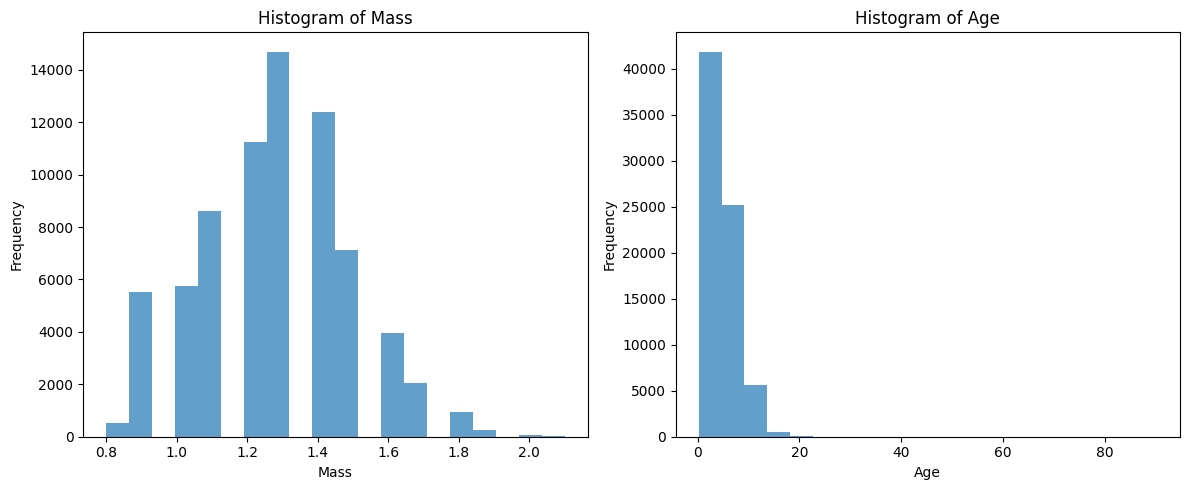

In [37]:
# Plot the histogram of mass and age of the stars.


plt.figure(figsize=(12, 5))

#  for mass
plt.subplot(1, 2, 1)
plt.hist(df_planets["mass"], bins=20, alpha=0.7)
plt.title("Histogram of Mass")
plt.xlabel("Mass")
plt.ylabel("Frequency")

# for age
plt.subplot(1, 2, 2)
plt.hist(df_planets["age"], bins=20, alpha=0.7)
plt.title("Histogram of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Mass distribution is similer to a Gaussian distribution but age distribution isn't.




Correlation Matrix:
             RAdeg     Dedeg      Teff    log(g)    [Fe/H]    [a/Fe]   mass_in  \
RAdeg    1.000000 -0.082507 -0.216513 -0.061265  0.172894  0.110974 -0.040904   
Dedeg   -0.082507  1.000000  0.118986  0.073090 -0.018776 -0.067128  0.037786   
Teff    -0.216513  0.118986  1.000000  0.786148 -0.106859 -0.038565  0.115920   
log(g)  -0.061265  0.073090  0.786148  1.000000  0.086384  0.038440 -0.013332   
[Fe/H]   0.172894 -0.018776 -0.106859  0.086384  1.000000 -0.646806  0.294142   
[a/Fe]   0.110974 -0.067128 -0.038565  0.038440 -0.646806  1.000000 -0.399133   
mass_in -0.040904  0.037786  0.115920 -0.013332  0.294142 -0.399133  1.000000   
mass    -0.119134  0.074047  0.176444  0.088136  0.515368 -0.775542  0.474632   
age      0.228941 -0.109177 -0.261518  0.071742 -0.173031  0.577030 -0.502568   

             mass       age  
RAdeg   -0.119134  0.228941  
Dedeg    0.074047 -0.109177  
Teff     0.176444 -0.261518  
log(g)   0.088136  0.071742  
[Fe/H]   0.515368 

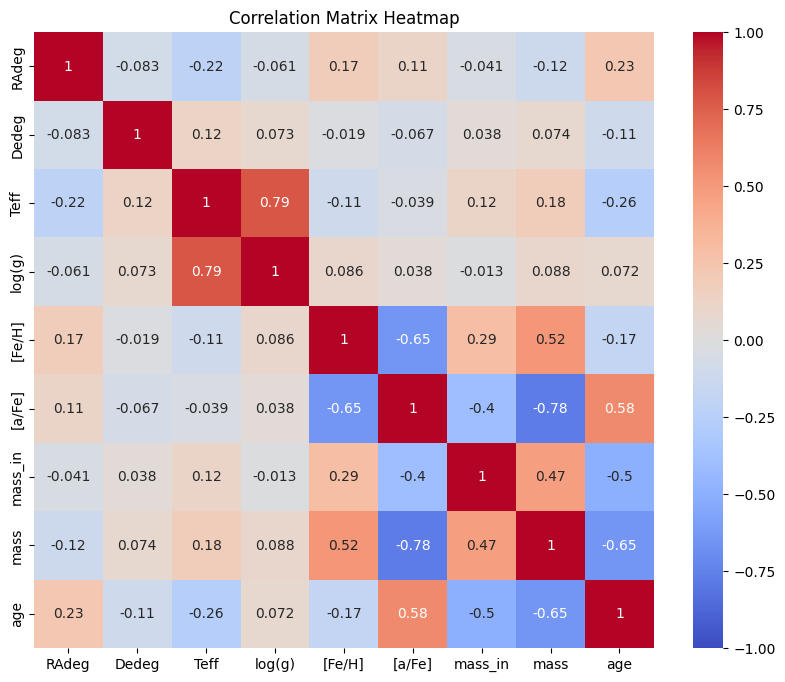

In [41]:
# https://www.geeksforgeeks.org/create-a-correlation-matrix-using-python/

import seaborn as sns

# The correlation matrix of the dataset
correlation_matrix = df_planets.corr()

# Print the correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [48]:
if correlation_matrix.equals(df_planets.corr(method='pearson')):
    print("The correlation matrix is Pearson so there is a linear relationships.")
else:
    print("The correlation matrix isn't Pearson so there isn't a linear relationships.")

The correlation matrix is Pearson so there is a linear relationships.


Let's examine the heatmap. There are some high postive correlations like "mass" and "Fe/H"; "age" and "Fe/H". Also there are high negative correlations such as "mass" and "a/Fe"; age and mass. High and low correlations are uset for prediction but correlations close to 0 are not used like "log(g)" and "mass_in"

## Data splitting

# Simple Perceptron

## Initial Model Architecture

## Compile and Training

## Model Performance

### Loss and MSE

### $R^2$ Score

# Multilayer Perceptron

## Initial MLP

## Optimization

### Data scaling

### Helpfull layers

### Regularization

### Epochs

# Conclusion